### Validating Multi-view Co-regularized Spectral Clustering on Simulated Data

Here we will validate our implementation of multi-view coregularized spectral clustering by comparing clustering results with those produced by the code associated with the original multi-view co-regularized spectral clustering paper [#3Clu]. 

In [13]:
import numpy as np
from numpy.random import multivariate_normal
from mvlearn.cluster.mv_coreg_spectral import MultiviewCoRegSpectralClustering
from sklearn.datasets import make_moons
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.io import savemat
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
RANDOM_SEED=10

##### A function to generate 2 views of data for 2 classes

This function takes parameters for means, variances, and number of samples for class and generates data based on those parameters. The underlying probability distribution of the data is a multivariate gaussian distribution.

In [2]:
def create_data(seed, vmeans, vvars, num_per_class=500):
    
    np.random.seed(seed)
    data = [[],[]]
    
    for view in range(2):
        for comp in range(len(vmeans[0])):
            cov = np.eye(2) * vvars[view][comp]
            comp_samples = np.random.multivariate_normal(vmeans[view][comp], cov, size=num_per_class)
            data[view].append(comp_samples)
    for view in range(2):
        data[view] = np.vstack(data[view])
    
    labels = list()
    for ind in range(len(vmeans[0])):
        labels.append(ind * np.ones(num_per_class,))
    
    labels = np.concatenate(labels)
    
    return data, labels

##### Creating a function to display data and the results of clustering

The following function plots both views of data given a dataset and corresponding labels.

In [3]:
def display_plots(pre_title, data, labels):
    
    # plot the views
    plt.figure()
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    dot_size=10
    ax[0].scatter(data[0][:, 0], data[0][:, 1],c=labels,s=dot_size)
    ax[0].set_title(pre_title + ' View 1')
    ax[0].axes.get_xaxis().set_visible(False)
    ax[0].axes.get_yaxis().set_visible(False)

    ax[1].scatter(data[1][:, 0], data[1][:, 1],c=labels,s=dot_size)
    ax[1].set_title(pre_title + ' View 2')
    ax[1].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_yaxis().set_visible(False)

    plt.show()

### Experiments

Here, we check whether or not the clustering results between the two implementations are the same or not. The implementation denoted as "Multi-view Clustering" is the version implemented in this package. The implementation denoted as "Matlab implementation" is produced by the author's of the original multi-view co-regularized spectral clustering paper and is written in matlab.

##### Clustering views comprised of simple multivariate gaussian distributions where components are easily separable in both views.

Cluster components 1:
* Mean: [3, 3] (both views)
* Covariance = I (both views)

Cluster components 2:
* Mean = [0, 0] (both views)
* Covariance = I (both views)


<Figure size 432x288 with 0 Axes>

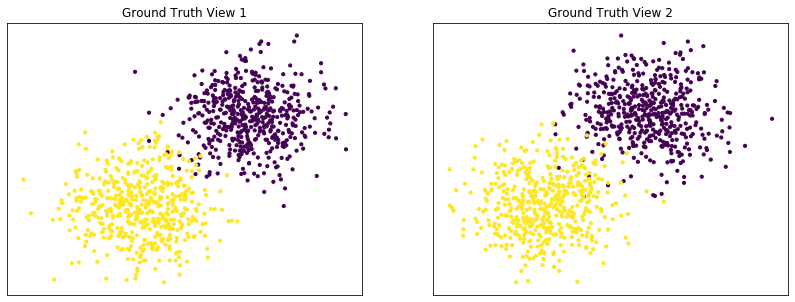

<Figure size 432x288 with 0 Axes>

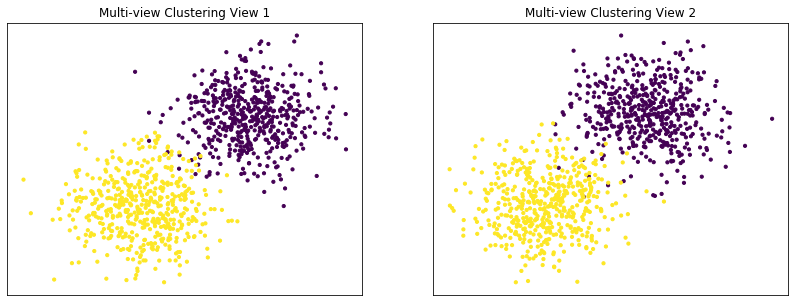

In [4]:
v1_means = [[3, 3], [0, 0]]
v2_means = [[3, 3], [0, 0]]
v1_vars = [1, 1]
v2_vars = [1, 1]
vmeans = [v1_means, v2_means]
vvars = [v1_vars, v2_vars]

data, labels = create_data(RANDOM_SEED, vmeans, vvars)
m_spectral = MultiviewCoRegSpectralClustering(n_clusters=2, info_view=0,
                random_state=RANDOM_SEED, n_init=100)
m_clusters = m_spectral.fit_predict(data)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

data = np.stack(data)
items = dict()
items['X1'] = data[0]
items['X2'] = data[1]
items['truth'] = labels
savemat('mv_gaussian_data1.mat', items)

<Figure size 432x288 with 0 Axes>

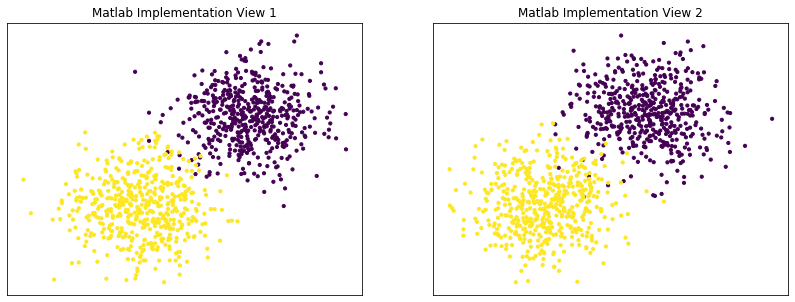

In [7]:
matlab_labels = np.loadtxt('../matlab_clusters_gaussian1.csv', delimiter=',')
matlab_labels = (1 - matlab_labels) # Switch colors
display_plots('Matlab Implementation' ,data, matlab_labels)

##### We will now run kmeans on the final spectral embedding over 50 trials and compare the average cluster nmi between the two implementations

Text(0, 0.5, 'NMI')

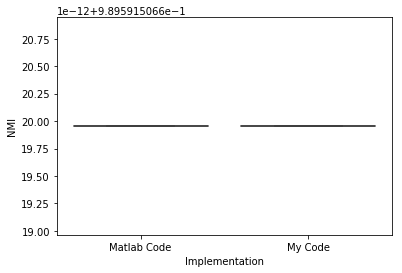

In [14]:
# Run 50 trials for python implementation and compute nmi values
n_trials = 50
nmi_vals = list()
embedding = m_spectral._embedding
for _ in range(n_trials):
    kmeans = KMeans(n_clusters=2, n_init=1)
    preds = kmeans.fit_predict(embedding)
    nmi_vals.append(nmi_score(preds, labels, average_method='arithmetic'))
nmi_vals = np.array(nmi_vals)

# Import results from matlab implementation
matlab_nmi = np.loadtxt('../matlab_nmi_gaussian1.csv', delimiter=',')

# Plot the results
df = pd.DataFrame(np.vstack([matlab_nmi, nmi_vals]).T, columns=['Matlab Code', 'My Code'])
ax = sns.boxplot(data=df)
plt.xlabel('Implementation')
plt.ylabel('NMI')

##### Clustering views comprised of simple multivariate gaussians where components are relatively inseparable (highly overlapping) in both viewssomewhat separable (somewhat overlapping) in both views

Cluster components 1:
* Mean: [1.5, 1.5] (both views)
* Covariance = I (both views)

Cluster components 2:
* Mean = [0, 0] (both views)
* Covariance = I (both views)


<Figure size 432x288 with 0 Axes>

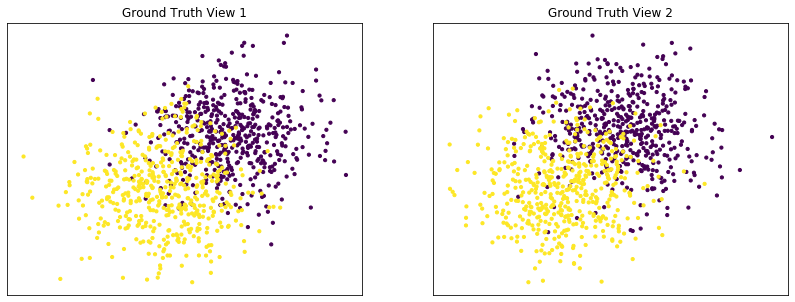

<Figure size 432x288 with 0 Axes>

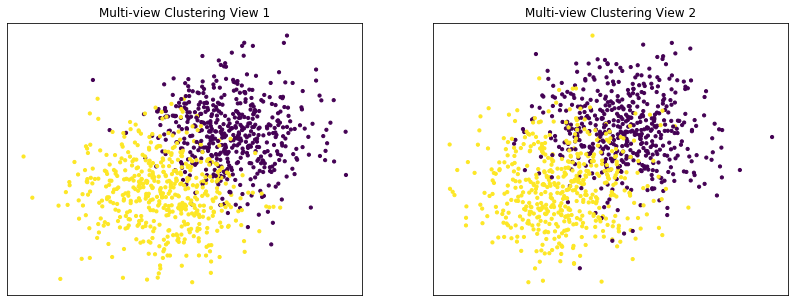

In [16]:
v1_means = [[1.5, 1.5], [0, 0]]
v2_means = [[1.5, 1.5], [0, 0]]
v1_vars = [1, 1]
v2_vars = [1, 1]
vmeans = [v1_means, v2_means]
vvars = [v1_vars, v2_vars]

data, labels = create_data(RANDOM_SEED, vmeans, vvars)
m_spectral = MultiviewCoRegSpectralClustering(n_clusters=2, info_view=0,
                random_state=RANDOM_SEED, n_init=100)
m_clusters = m_spectral.fit_predict(data)
m_clusters = 1 - m_clusters # Flip the colors to make them match

display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)
data = np.stack(data)
items = dict()
items['X1'] = data[0]
items['X2'] = data[1]
items['truth'] = labels
savemat('mv_gaussian_data2.mat', items)

<Figure size 432x288 with 0 Axes>

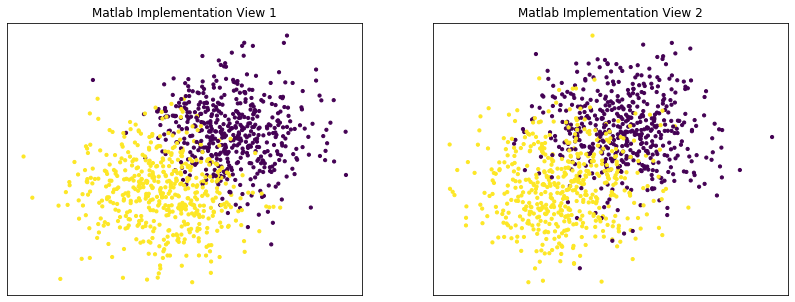

In [18]:
matlab_labels = np.loadtxt('../matlab_clusters_gaussian2.csv', delimiter=',')
display_plots('Matlab Implementation' ,data, matlab_labels)

##### We will now run kmeans on the final spectral embedding over 50 trials and compare the average cluster nmi between the two implementations

Text(0, 0.5, 'NMI')

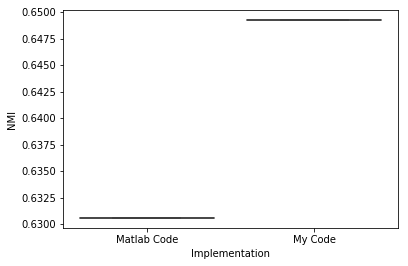

In [19]:
# Run 50 trials for python implementation and compute nmi values
n_trials = 50
nmi_vals = list()
embedding = m_spectral._embedding
for _ in range(n_trials):
    kmeans = KMeans(n_clusters=2, n_init=1)
    preds = kmeans.fit_predict(embedding)
    nmi_vals.append(nmi_score(preds, labels, average_method='arithmetic'))
nmi_vals = np.array(nmi_vals)

# Import results from matlab implementation
matlab_nmi = np.loadtxt('../matlab_nmi_gaussian2.csv', delimiter=',')

# Plot the results
df = pd.DataFrame(np.vstack([matlab_nmi, nmi_vals]).T, columns=['Matlab Code', 'My Code'])
ax = sns.boxplot(data=df)
plt.xlabel('Implementation')
plt.ylabel('NMI')

In [20]:
def create_moons(seed, num_per_class=500):
    
    np.random.seed(seed)
    data = []
    labels = []
    
    for view in range(2):
        v_dat, v_labs = make_moons(num_per_class*2, 
                random_state=seed + view, noise=0.1, shuffle=False)
        if view == 1:
            v_dat = v_dat[:, ::-1]
        
        data.append(v_dat)
    for ind in range(len(data)):
        labels.append(ind * np.ones(num_per_class,))
    labels = np.concatenate(labels)
    
    return data, labels

##### Performance on moons data

For this experiment, we use the sklearn make_moons function to make two interleaving half circles. We then use spectral clustering to separate the two views. In this experiment, the two views are identical.

<Figure size 432x288 with 0 Axes>

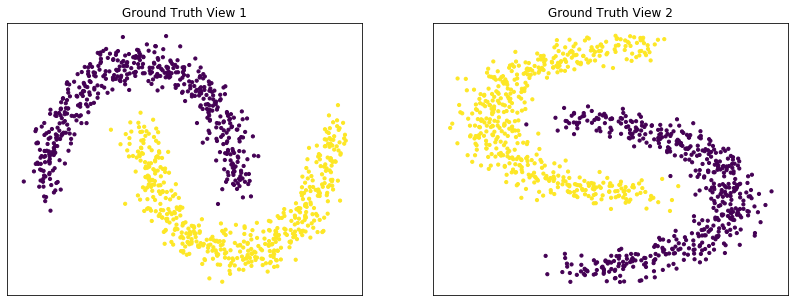

<Figure size 432x288 with 0 Axes>

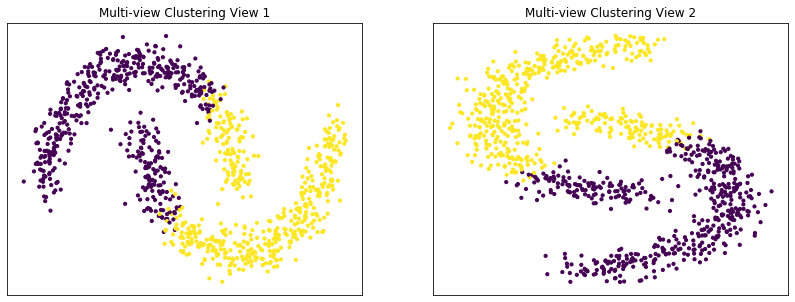

In [21]:
data, labels = create_moons(RANDOM_SEED)
m_spectral = MultiviewCoRegSpectralClustering(n_clusters=2, info_view=0,
                random_state=RANDOM_SEED, n_init=100)
m_clusters = m_spectral.fit_predict(data)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

data = np.stack(data)
items = dict()
items['X1'] = data[0]
items['X2'] = data[1]
items['truth'] = labels
savemat('mv_moons_data1.mat', items)

<Figure size 432x288 with 0 Axes>

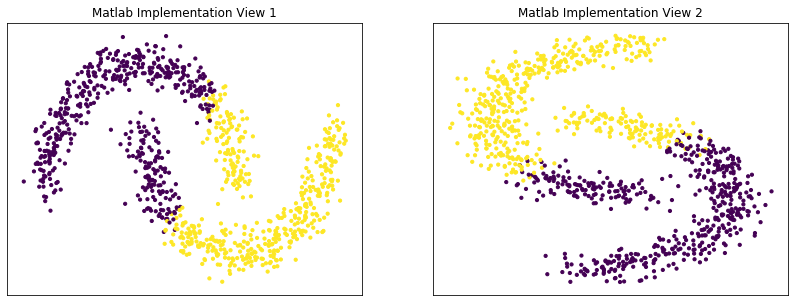

In [28]:
matlab_labels = np.loadtxt('../matlab_clusters_moons1.csv', delimiter=',')
matlab_labels = 2 - matlab_labels
display_plots('Matlab Implementation' ,data, matlab_labels)

In [ ]:
# Run 50 trials for python implementation and compute nmi values
n_trials = 50
nmi_vals = list()
embedding = m_spectral._embedding
for _ in range(n_trials):
    kmeans = KMeans(n_clusters=2, n_init=1)
    preds = kmeans.fit_predict(embedding)
    nmi_vals.append(nmi_score(preds, labels, average_method='arithmetic'))
nmi_vals = np.array(nmi_vals)

# Import results from matlab implementation
matlab_nmi = np.loadtxt('../matlab_nmi_gaussian2.csv', delimiter=',')

# Plot the results
df = pd.DataFrame(np.vstack([matlab_nmi, nmi_vals]).T, columns=['Matlab Code', 'My Code'])
ax = sns.boxplot(data=df)
plt.xlabel('Implementation')
plt.ylabel('NMI')

##### Conclusions

From the above experiments, we can see that this implementation and the matplab implementation of multi-view spectral clustering from the paper both produce the same clustering results, which provides evidence that the implementations are equivalent.